This notebook follows "badgradientMCMC" and develops an MCMC walker that uses the Metropolis-Hastings algorithm.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

**Exercise 1**

As we discussed yesterday, an MCMC algorithm which only moves in the direction of increasing likelihood is very susceptible to getting trapped in local $\chi^2$ minima, and may not be able to find the global solution.

The function below is one such example.  If we had a likelihood space like this, we would never find the global minimum!  Execute the two sections below to see what it looks like.

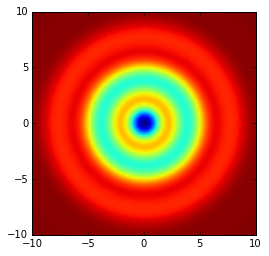

In [2]:
def wavygaussian(x, y, a=5., mu=0., sig=4., omega=1.5):
    r = np.sqrt(x**2 + y**2)
    z = -1*(a*np.exp(-(r - mu)**2 / (2 * sig**2))*(2+np.cos(omega*r))) + 3*a
    return z

xplot = np.linspace(-10, 10, 100)
yplot = np.linspace(-10, 10, 100)
zplot = np.zeros([100,100])
for i in range(0,100):
    for j in range(0,100):
        zplot[i,j] = wavygaussian(xplot[i], yplot[j])
        
plt.imshow(np.flipud(zplot.T), extent=[-10, 10, -10, 10])

Below is a 1-d slice across the middle.

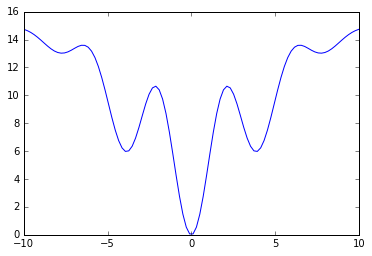

In [3]:
plt.plot(yplot, wavygaussian(0,yplot))

If the plot above shows $\chi^2$, what is the likelihood?

**To do:** Plot the likelihood in a slice across x=0.

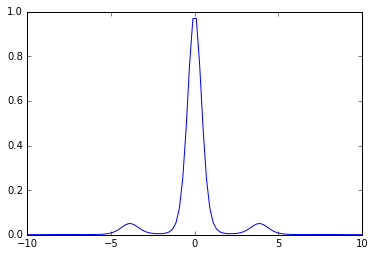

In [4]:
# YOUR CODE HERE
plt.plot(yplot, np.exp(-wavygaussian(0,yplot)/2))

Let's take our "bad gradient MCMC" code from yesterday.  It will need to be modified to use "wavygaussian" instead of "chi2".  

**To do:** Make that modification and execute the code.  What happens?  Does changing the step size or number of steps help?  (Hint: There is actually a way to get to the likelihood maximum from (3,3) with this algorithm - see if you can find it!)

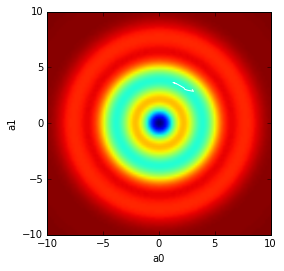

In [14]:
# Initial location
a0 = 3.
a1 = 3.
# Step sizes (sigmas of normal distributions)
da0 = 0.3
da1 = 0.3
# Total number of steps to take
nsteps = 10000
# Lists for keeping track of location
a0list = [a0]
a1list = [a1]

for i in range(0,nsteps):
    # Draw values for delta a0 and delta a1 from a normal distribution
    a0step = np.random.normal(scale=da0)
    a1step = np.random.normal(scale=da1)
    # MODIFY THE LINE BELOW
    # if chi2(a0 + a0step, a1 + a1step, Mstar, Rstar, Merr, Rerr) < chi2(a0, a1, Mstar, Rstar, Merr, Rerr):
    if wavygaussian(a0 + a0step, a1 + a1step) < wavygaussian(a0, a1):
        a0 += a0step
        a1 += a1step
    
    a0list.append(a0)
    a1list.append(a1)

plt.imshow(np.flipud(zplot.T), extent=[-10, 10, -10, 10])
plt.axis([-10,10,-10,10])
plt.xlabel('a0')
plt.ylabel('a1')
plt.plot(a0list, a1list, '-', color='white', ms=2, markeredgewidth=0)  

**Exercise 2**

According to the Metropolis-Hastings algorithm, we should not immediately reject any step that would decrease the likelihood.  Instead, we should sometimes allow it to take that step, with a probability proportional to the likelihood ratio.

Concretely, what this would look like is an "else" block after the "if", which

1) Calculates the likelihood ratio,

2) Draws a random number between 0 and 1, and

3) Accepts the step if the likelihood ratio is above that value.

**To do:** Implement this else block.  Then, mess around with the parameters again and see what happens!

Hint: for step 2 you may want to use the function "np.random.uniform".  If you are not familiar with this function, google it!

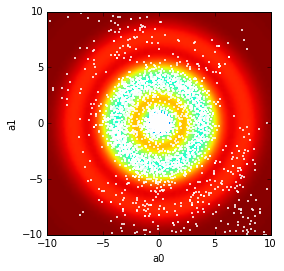

In [15]:
# Initial location
a0 = 3.
a1 = 3.
# Step sizes (sigmas of normal distributions)
da0 = 1.
da1 = 1.
# Total number of steps to take
nsteps = 100000
# Lists for keeping track of location
a0list = [a0]
a1list = [a1]

for i in range(0,nsteps):
    # Draw values for delta a0 and delta a1 from a normal distribution
    a0step = np.random.normal(scale=da0)
    a1step = np.random.normal(scale=da1)
    if wavygaussian(a0 + a0step, a1 + a1step) < wavygaussian(a0, a1):
        a0 += a0step
        a1 += a1step
    else:  # IMPLEMENT THIS
        # r = the likelihood ratio
        # u = a random number between 0 and 1
        # accept the step if r > u
        r = np.math.exp((- wavygaussian(a0 + a0step, a1 + a1step) + wavygaussian(a0, a1))/2.)
        u = np.random.uniform(0., 1.)
        if r > u:
            a0 += a0step
            a1 += a1step
    
    a0list.append(a0)
    a1list.append(a1)

plt.imshow(np.flipud(zplot.T), extent=[-10, 10, -10, 10])
plt.axis([-10,10,-10,10])
plt.xlabel('a0')
plt.ylabel('a1')
plt.plot(a0list, a1list, 'o', color='white', ms=2, markeredgewidth=0)  

There are a few useful/interesting plots that we can make using that sequence of a0 and a1 values.  In particular, since the distribution has spherical symmetry, we are most interested in the radial distance r. 

**To do:** Define a variable rlist that is the radial distance from (0,0) for each of your MCMC steps.  Plot the radial distance as a function of time.  What interesting features does this sequence have?  How does it correspond to the $\chi^2$ distribution we plotted earlier?

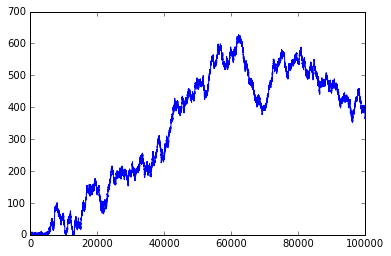

In [16]:
# FINISH THIS LINE
rlist = np.sqrt(np.array(a0list)**2 + np.array(a1list)**2)
plt.plot(rlist)

If the Metropolis-Hastings algorithm is truly *ergodic*, then the distribution of r-values visited by our walker should correspond to the underlying likelihood that we plotted earlier (assuming that we have taken enough steps).  

The code below computes a histogram of your list of r-values.  We can evaluate the performance of the algorithm by comparing this histogram to the likelihood - but they are not directly comparable as the code is currently written.  There is a missing step which transforms / normalizes the histogram so that the two can be compared.

**To do:** Think about the meaning behind (a) the likelihood we are plotting, and (b) the histogram we have calculated.  What is the necessary transformation?  Implement it, and then (as always) mess around with the MCMC parameters to see how the distribution changes.

Hint: If you are not matching the likelihood distribution after implementing your transformation, it is not necessarily because you have done it incorrectly - you may just have a non-representative set of r-values.  Try changing the MCMC parameters or simply rerunning it before giving up on your solution!

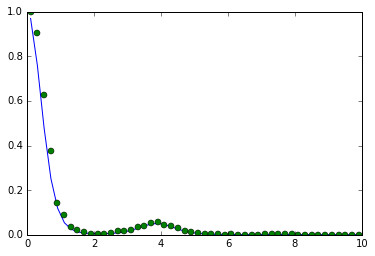

In [17]:
# Computes a histogram of r-values.  Note that hist has length 50 and edges has length 51.
hist, edges = np.histogram(rlist, bins=50, range=(0,10))
# Calculates the location of the center of each histogram bin
mids = (edges[1:]+edges[:-1])/2.

# Plots a slice in likelihood across x = 0, from y = 0 to 10
plt.plot(yplot[50:], np.exp(-wavygaussian(0,yplot[50:])/2.))

# TO DO: How do you need to normalize / transform the histogram to get it to be 
# comparable to the likelihood as we have plotted it?
hist = hist/np.max(hist/mids)/mids

# Plots the transformed histogram as points
plt.plot(mids,hist, 'o')

**Exercise 3**

Now, let's return to the dataset we have been using throughout the week.  The code block below has the same functionality as yesterday, the differences being that I have renamed chi2 into chi2line, changed the structure of the arguments, and made it a "reduced $\chi^2$" (i.e., divided out the number of degrees of freedom).  Take a look to make sure you understand how the changes work.

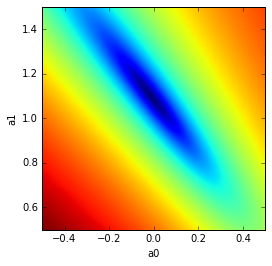

In [18]:
data = np.loadtxt('Lopez-Morales07_table1.txt', comments=';', delimiter=',')
Mstar = data[:,0]
Merr = data[:,1]
Rstar = data[:,2]
Rerr = data[:,3]

def chi2line(p, xi, yi, err): 
    ''' Calculates chi^2 between the data (xi, yi) and the line described by y = p[0] + p[1]*x
    
        Input
        =====
        p : An array of parameter values.  The first element is the y-intercept 
            of the model and the second element is the slope.
        xi : array of x-values from the data
        yi : array of y-values from the data
        err : A 2xN array of the expected variance of each data point, where the 
            first column corresponds to the x-errors and the second to the y-errors            
    '''

    chi2 = np.sum((p[0] + p[1]*xi - yi)**2/(err[1,:]**2+(err[0,:]*p[1])**2))/(len(xi)-1)
    
    return chi2 

a0grid = np.linspace(-0.5, 0.5, 100)
a1grid = np.linspace(0.5, 1.5, 100)
chi2grid = np.zeros((100,100))

for i in range(0,100):
    for j in range(0,100):
        chi2grid[i,j] = chi2line([a0grid[i],a1grid[j]],Mstar,Rstar,np.array([Merr,Rerr]))
        
plt.imshow(np.flipud(np.log10(chi2grid).T), extent=[-0.5, 0.5, 0.5, 1.5])
plt.xlabel('a0')
plt.ylabel('a1')

Let's apply our Metropolis-Hastings MCMC algorithm to this dataset!

**To do:** Copy your MCMC code from above and modify it to apply to the dataset.  Keep in mind how the chi2 function has been rearranged!

**Stretch goal:** Instead of rewriting the same code all over again every time you want to run an MCMC, try writing a more general MCMC function that can be applied to any problem!  I have gotten you started with a suggested interface in the next block.

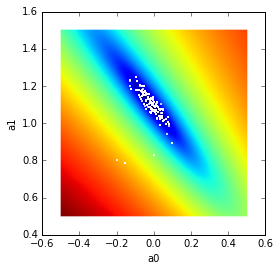

In [20]:
# Initial location
a0 = -0.2
a1 = 0.8
# Step sizes (sigmas of normal distributions)
da0 = 0.1
da1 = 0.1
# Total number of steps to take
nsteps = 1000
# Lists for keeping track of location
a0list = [a0]
a1list = [a1]

#YOUR CODE HERE
errs = np.array([Merr,Rerr])

for i in range(0,nsteps):
    # Draw values for delta a0 and delta a1 from a normal distribution
    a0step = np.random.normal(scale=da0)
    a1step = np.random.normal(scale=da1)
    # IF the chi2 value is lower (likelihood is higher) at the new location,
    if chi2line([a0 + a0step, a1 + a1step], Mstar, Rstar, errs) < chi2line([a0, a1], Mstar, Rstar, errs):
        a0 += a0step
        a1 += a1step
    else:
        r = np.math.exp((- chi2line([a0 + a0step, a1 + a1step], Mstar, Rstar, errs) + chi2line([a0, a1], Mstar, Rstar, errs))/2.)
        u = np.random.uniform(0., 1.)
        if r > u:
            a0 += a0step
            a1 += a1step

    a0list.append(a0)
    a1list.append(a1)

plt.imshow(np.flipud(np.log10(chi2grid).T), extent=[-0.5, 0.5, 0.5, 1.5])
plt.xlabel('a0')
plt.ylabel('a1')
plt.plot(a0list, a1list, 'o', color='white', ms=2, markeredgewidth=0)  

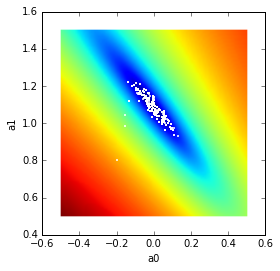

In [243]:
# Initial location
pinit = np.array([-0.2, 0.8])
# Step sizes (sigmas of normal distributions)
stepsize = np.array([0.1, 0.1])
# Total number of steps to take
nsteps = 1000

def mhMCMC(xi, yi, err, chi2func, initparams, stepsize, nsteps):
    ''' Performs a Markov Chain Monte Carlo chain using the Metropolis-Hastings algorithm
        to explore the parameter space for the given model and data.  Returns the sequence
        of steps taken.
    
        Input
        =====
        xi : An array giving the x-values of the data
        yi : An array giving the y-values of the data
        err : An array giving the errors on the data.  
              May be 1xN (for y-errors only) or 2xN (for x- and y- errors), 
              must match what's expected by chi2func.
        chi2func : A function which calculates the chi-squared between the data
                   and model.  Must take arguments (params, xi, yi, err).
        initparams : An array [a0, a1, a2...] giving the initial position in parameter space.
        stepsize : An array [da0, da1, da2...] giving the sigma of the normal distributions
                   from which the steps are drawn.  Must be the same length as initparams.
        nsteps : The number of steps to take.
                
        Returns
        =======
        p : An array of positions in parameter space, with dimensions (nsteps+1, nparams)
    '''
    p = initparams
    plist = [p]
    
    for i in range(0,nsteps):
        # Draw a step size for each parameter
        dp = np.zeros(len(p))
        for j in range(0,len(p)):
            dp[j] = np.random.normal(scale=stepsize[j])
            
        # Check out the chi2 at the new location
        if chi2func(p + dp, xi, yi, err) < chi2func(p, xi, yi, err):
            # Accept the step if the likelihood is higher
            p = p + dp
        else:
            # Evaluate the likelihood ratio
            r = np.math.exp((chi2func(p, xi, yi, err) - chi2func(p + dp, xi, yi, err))/2.)
            # Accept the step if the random number drawn is lower than the likelihood ratio
            u = np.random.uniform(0., 1.)
            if r > u:
                p = p + dp
    
        plist.append(p)

    return np.array(plist)

# Run the MCMC!
p = mhMCMC(Mstar, Rstar, np.array([Merr,Rerr]), chi2line, pinit, stepsize, nsteps)

# Plotting
plt.imshow(np.flipud(np.log10(chi2grid).T), extent=[-0.5, 0.5, 0.5, 1.5])
plt.xlabel('a0')
plt.ylabel('a1')
plt.plot(p[:,0], p[:,1], 'o', color='white', ms=2, markeredgewidth=0)  

**To do:** Make a histogram of the a0 and a1 values, and find the median and mean of these distributions.  How do they compare to the best-fit values we got earlier?

And, you don't need me to tell you again - explore what happens when you change the MCMC parameters!

(array([   1.,    6.,   11.,   47.,  146.,  197.,  379.,  118.,   59.,   37.]),
 array([-0.2       , -0.16996183, -0.13992365, -0.10988548, -0.07984731,
        -0.04980913, -0.01977096,  0.01026722,  0.04030539,  0.07034356,
         0.10038174]),
 <a list of 10 Patch objects>)

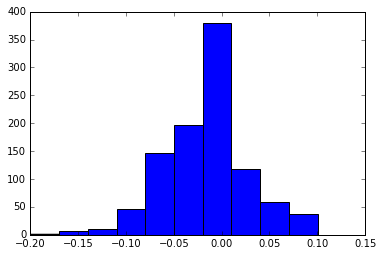

In [21]:
# YOUR CODE HERE
plt.hist(a0list)

(array([   8.,    0.,    2.,    1.,   52.,  107.,  375.,  242.,  187.,   27.]),
 array([ 0.78855595,  0.8345827 ,  0.88060944,  0.92663619,  0.97266294,
         1.01868969,  1.06471643,  1.11074318,  1.15676993,  1.20279668,
         1.24882342]),
 <a list of 10 Patch objects>)

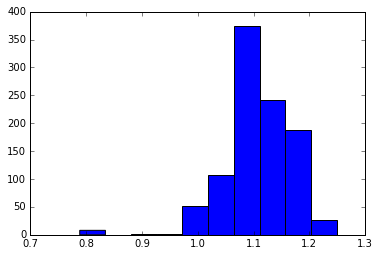

In [22]:
plt.hist(a1list)

In [73]:
print(np.median(a0list), np.median(a1list))

-0.0138985839404 1.09964999212


In [247]:
print(np.mean(a0list), np.mean(a1list))

-0.019783400752 1.10408427795
